In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyvallocation.views import FlexibleViewsProcessor, BlackLittermanProcessor
from pyvallocation.portfolioapi import AssetsDistribution, PortfolioWrapper
from pyvallocation import probabilities, moments

plt.style.use("default")
np.set_printoptions(precision=4, suppress=True)

# Load price data

Tickers: ['DBC', 'GLD', 'SPY', 'TLT']


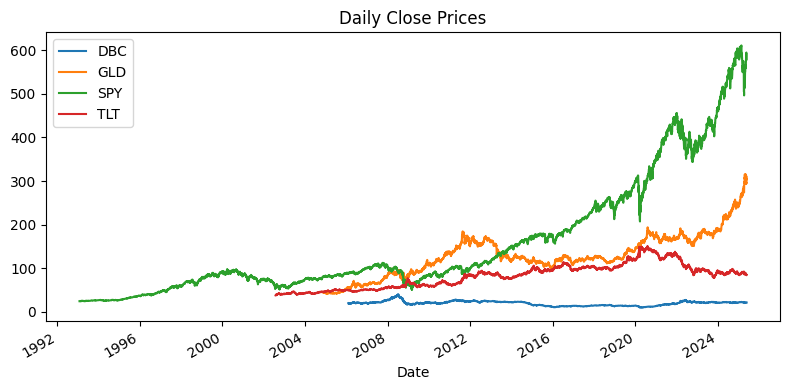

In [2]:
prices = pd.read_csv("../examples/ETF_prices.csv", index_col=0, parse_dates=True)
print("Tickers:", list(prices.columns))
prices.head()

prices.plot(figsize=(8,4), title="Daily Close Prices")
plt.tight_layout()

# Weekly returns as risk drivers

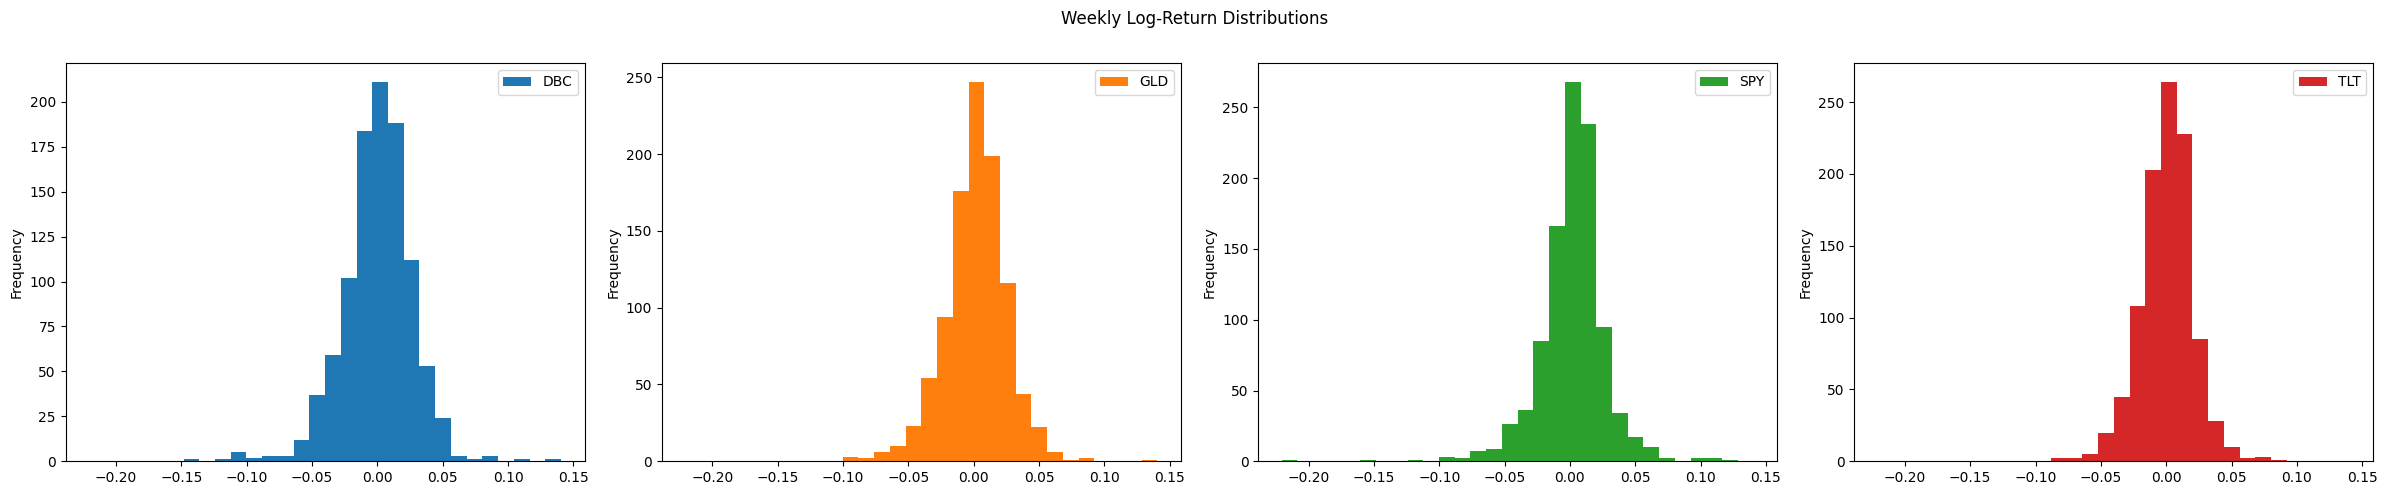

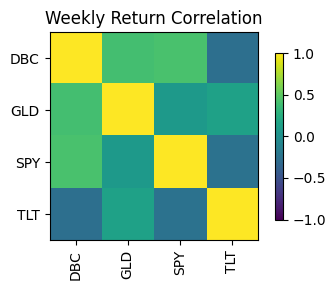

In [3]:
weekly_prices = prices.resample("W").ffill()
weekly_ret = np.log(weekly_prices).diff().dropna()
T, N = weekly_ret.shape
ANNUALIZE = 52  # weeks per year

weekly_ret.plot(kind="hist", subplots=True, bins=30, sharex=True, layout=(1,N), figsize=(6*N,5))
plt.suptitle("Weekly Log‑Return Distributions"); plt.tight_layout(rect=[0,0,1,0.97])

corr = weekly_ret.corr()
fig, ax = plt.subplots(figsize=(4,3))
im = ax.imshow(corr, vmin=-1, vmax=1)
ax.set_xticks(range(N)); ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticks(range(N)); ax.set_yticklabels(corr.columns)
fig.colorbar(im, ax=ax, shrink=0.8)
ax.set_title("Weekly Return Correlation"); plt.tight_layout();

# Scenario probabilities

In [4]:
p = probabilities.generate_uniform_probabilities(T)
print("Effective # scenarios:", probabilities.compute_effective_number_scenarios(p))

Effective # scenarios: 1006.0000000000003


# Moment estimation + shrinkage

In [5]:
mu,  Σ = moments.estimate_sample_moments(weekly_ret, p)
print("Sample μ (annualized):\n", (mu*ANNUALIZE).round(4))

mu_jorion = moments.shrink_mean_jorion(mu, Σ, T)
Σ_lw_cc   = moments.shrink_covariance_ledoit_wolf(weekly_ret, Σ, target="constant_correlation")

Sample μ (annualized):
 DBC    0.0062
GLD    0.0895
SPY    0.0973
TLT    0.0276
Name: mu, dtype: float64


# Market equilibrium & risk aversion

In [6]:
mkt = pd.Series({"DBC":0.05, "GLD":0.05, "SPY":0.40, "TLT":0.50})
market_rets = weekly_ret @ mkt
λ = market_rets.mean() / market_rets.var()
print("Risk‑aversion λ:", round(λ,4))

Risk‑aversion λ: 6.7256


# Views

In [7]:
views = {"SPY":0.06/ANNUALIZE, "GLD":0.03/ANNUALIZE}

# Black–Litterman posterior (baseline)

In [8]:
bl = BlackLittermanProcessor(
    prior_cov   = Σ_lw_cc,
    market_weights = mkt,
    mean_views  = views,
    risk_aversion = λ,
    tau = 0.05,
    verbose=True
)
mu_bl, Σ_bl = bl.get_posterior()
print("Posterior μ (annualized):\n", (mu_bl*ANNUALIZE).round(4))

[BL] Prior mean source: reverse-optimized from 'market_weights'.
[BL] Built P matrix ((2, 4)) and Q vector ((2, 1)) for 2 views.
[BL] Ω constructed as diag(P(τΣ)Pᵀ).
[BL] Posterior mean and covariance computed.
Posterior μ (annualized):
 DBC    0.0287
GLD    0.0307
SPY    0.0670
TLT    0.0505
dtype: float64


## Sensitivity: τ and λ

In [9]:
scan = []
for τ in [0.05, 1]:
    for lam in [λ, 1]:
        mu_tmp, _ = BlackLittermanProcessor(
            prior_cov=Σ_lw_cc,
            market_weights=mkt,
            mean_views=views,
            risk_aversion=lam,
            tau=τ,
        ).get_posterior()
        scan.append(pd.Series(mu_tmp*ANNUALIZE, name=f"tau={τ}, λ={lam}"))

pd.concat(scan, axis=1).T.round(4)

,DBC,GLD,SPY,TLT
"tau=0.05, λ=6.725638562294897",0.0287,0.0307,0.0670,0.0505
"tau=0.05, λ=1",0.0208,0.0182,0.0359,0.0041
"tau=1, λ=6.725638562294897",0.0287,0.0307,0.0670,0.0505
"tau=1, λ=1",0.0208,0.0182,0.0359,0.0041


#  Flexible views

In [15]:
fv = FlexibleViewsProcessor(
    prior_returns=weekly_ret,
    mean_views = views,
)
mu_fv, Σ_fv = fv.get_posterior()
print("FV posterior μ (annualized):\n", (mu_fv*ANNUALIZE).round(4))

FV posterior μ (annualized):
 DBC   -0.0349
GLD    0.0300
SPY    0.0600
TLT    0.0273
dtype: float64


# Compare priors vs posteriors visually

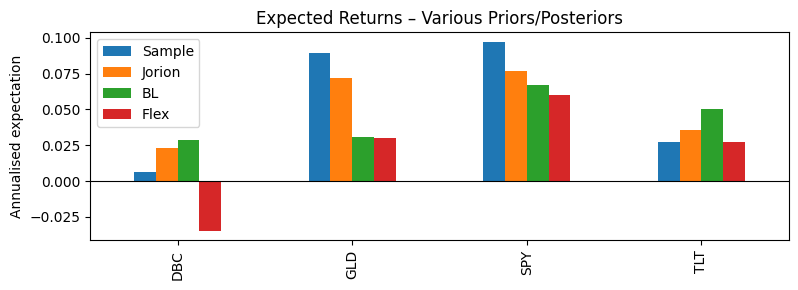

In [11]:
bar = pd.concat({
    "Sample": mu*ANNUALIZE,
    "Jorion": mu_jorion*ANNUALIZE,
    "BL":     mu_bl*ANNUALIZE,
    "Flex":   mu_fv*ANNUALIZE,
}, axis=1)
bar.plot(kind="bar", figsize=(8,3))
plt.ylabel("Annualised expectation")
plt.title("Expected Returns – Various Priors/Posteriors")
plt.axhline(0,color="black",linewidth=0.8); plt.tight_layout()

# Efficient frontier

[pyvallocation.portfolioapi - INFO] PortfolioWrapper initialized for 4 assets.
[pyvallocation.portfolioapi - WARNING] No constraints were set. To ensure a solvable problem, applying default constraints: long-only (weights >= 0) and fully-invested (weights sum to 1.0).
[pyvallocation.portfolioapi - INFO] Setting constraints with parameters: {'long_only': True, 'total_weight': 1.0}
[pyvallocation.portfolioapi - INFO] Successfully computed Mean-Variance frontier with 10 portfolios.
[pyvallocation.portfolioapi - INFO] PortfolioWrapper initialized for 4 assets.
[pyvallocation.portfolioapi - WARNING] No constraints were set. To ensure a solvable problem, applying default constraints: long-only (weights >= 0) and fully-invested (weights sum to 1.0).
[pyvallocation.portfolioapi - INFO] Setting constraints with parameters: {'long_only': True, 'total_weight': 1.0}
[pyvallocation.portfolioapi - INFO] Successfully computed Mean-Variance frontier with 10 portfolios.
[pyvallocation.portfolioapi - IN

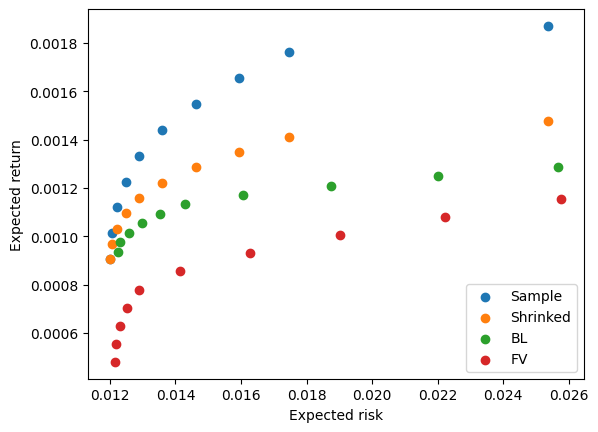

In [12]:
ef = PortfolioWrapper(AssetsDistribution(mu=mu,cov=Σ)).mean_variance_frontier()
plt.scatter(ef.risks,ef.returns,label='Sample')

ef_shrinked = PortfolioWrapper(AssetsDistribution(mu=mu_jorion,cov=Σ_lw_cc)).mean_variance_frontier()
plt.scatter(ef_shrinked.risks,ef_shrinked.returns,label='Shrinked')

ef_bl = PortfolioWrapper(AssetsDistribution(mu=mu_bl,cov=Σ_bl)).mean_variance_frontier()
plt.scatter(ef_bl.risks,ef_bl.returns,label='BL')

ef_fv = PortfolioWrapper(AssetsDistribution(mu=mu_fv,cov=Σ_fv)).mean_variance_frontier()
plt.scatter(ef_fv.risks,ef_fv.returns,label='FV')

plt.ylabel('Expected return')
plt.xlabel('Expected risk')
plt.legend()
plt.show()

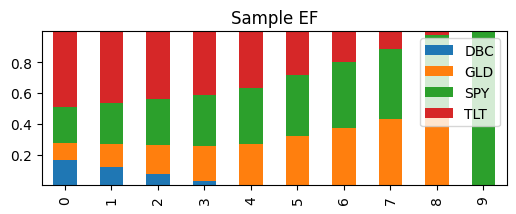

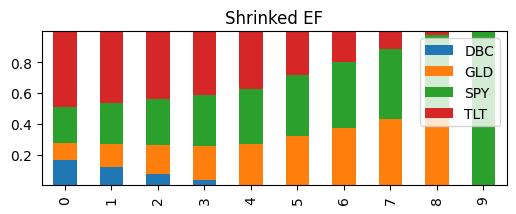

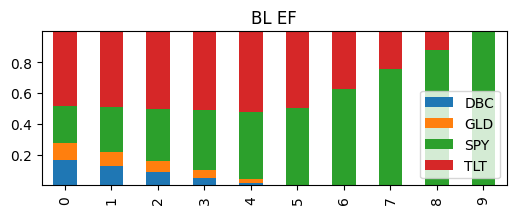

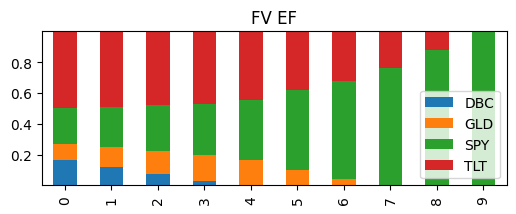

In [13]:
pd.DataFrame(ef.weights,index=weekly_prices.columns).T.plot.bar(stacked=True,title='Sample EF',figsize=(6,2)); plt.show()

pd.DataFrame(ef_shrinked.weights,index=weekly_prices.columns).T.plot.bar(stacked=True,title='Shrinked EF',figsize=(6,2)); plt.show()

pd.DataFrame(ef_bl.weights,index=weekly_prices.columns).T.plot.bar(stacked=True,title='BL EF',figsize=(6,2)); plt.show()

pd.DataFrame(ef_fv.weights,index=weekly_prices.columns).T.plot.bar(stacked=True,title='FV EF',figsize=(6,2)); plt.show()